In [1]:
%matplotlib inline
import rebound as r
r.reset()
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
r.status()
from IPython.html.widgets import interact, interactive
from IPython.display import display

---------------------------------
Rebound version:     	1.1.0
Build on:            	Jun 24 2015 10:13:57
Number of particles: 	0
Simulation time:     	0.000000
---------------------------------


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Simulated data:

In [13]:
def particleSetup(thetap):
    if len(thetap)==4:
        return r.Particle(primary=r.particles[0],a=thetap[0],e=np.clip(thetap[1],0.,1.),anom=thetap[2],omega=thetap[3])
    elif len(thetap)==2:
        return r.Particle(primary=r.particles[0],a=thetap[0],e=np.clip(thetap[1],0.,.4),anom=0.,omega=-np.pi/2.)
    elif len(thetap)==3:
        omega = np.arctan2(thetap[2],thetap[1])
        e = np.power(thetap[1]**2+thetap[2]**2,1./2.)
        if e>0.4 or e<0.:
            raise Exception("Eccentricity")
        return r.Particle(primary=r.particles[0],a=thetap[0],e=e, anom=0.,omega=omega)
    else:
        return r.Particle(primary=r.particles[0],a=thetap[0],e=0.2,anom=0.,omega=-np.pi/2.)

def getRV(thetar):
    r.reset()
    r.N_megnopp = len(thetar) 
    r.add(m=1.)
    r.add(particleSetup(thetar))
    ps = r.particles
    rvs = np.zeros(len(data_t))
    for i,t in enumerate(data_t):
        r.integrate(t)
        rvs[i] = ps[1].vx
    return rvs

def generateObs(thetao):
    data_N = 30
    global data_t, data_rv, N_param
    N_param = len(thetao)
    data_t = np.linspace(0.,50.,data_N)+0.0005*np.random.rand(data_N)
    data_rv = getRV(thetao)+0.001*(np.random.rand(data_N)-0.5)
    #plt.scatter(data_t, data_rv);

## Setting up simulations

Fails: 0. Acceptance rate: 82.1%


/Users/rein/git/rebound/venv/lib/python2.7/site-packages/IPython/kernel/__main__.py:147: RuntimeWarning: divide by zero encountered in log


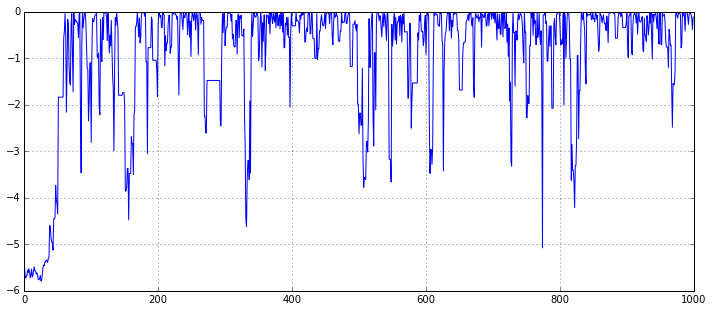

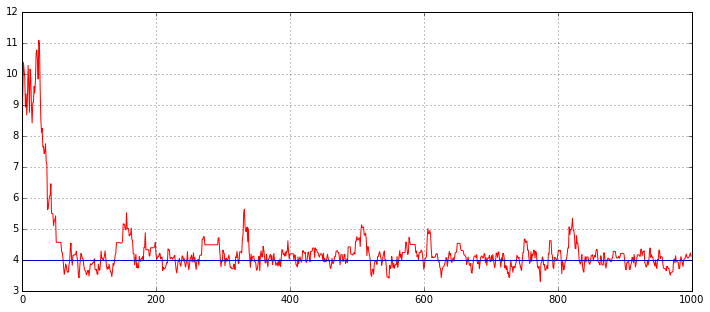

In [52]:
N = 2
def varid2(l,k):
    if k>l:
        raise Exception("error")
    if l>=N_param:
        raise Exception("error")
    var = l*(l+1)/2+k
    return var*N+1+N+N*N_param
def varid1(l):
    if l>=N_param:
        raise Exception("error")
    return N*l+1+N
    
def simulation(cart):
    r.reset()
    N_param = len(cart)
    r.N_megnopp = N_param 
    r.add(m=1.)
    op = particleSetup(cart)
    r.add(op)
    N = r.N
    r.init_megno(0.)
    ps = r.particles
    
    delta = 1e-4
    # First order
    for l in range(N_param):
        cart2 = cart.copy()
        cart2[l] += delta/2.
        mp = particleSetup(cart2)
        cart2 = cart.copy()
        cart2[l] -= delta/2.
        mm = particleSetup(cart2)

        vari = varid1(l)
        ps[vari].x  = (mp.x  - mm.x  )
        ps[vari].y  = (mp.y  - mm.y  )
        ps[vari].z  = (mp.z  - mm.z  )
        ps[vari].vx = (mp.vx - mm.vx )
        ps[vari].vy = (mp.vy - mm.vy )
        ps[vari].vz = (mp.vz - mm.vz )
        
    # Second order
    for l in range(N_param):
        for k in range(l+1):
            fac = 2.
            cart2 = cart.copy()
            cart2[l] += delta/fac
            cart2[k] += delta/fac
            mpp = particleSetup(cart2)
            cart2 = cart.copy()
            cart2[l] += delta/fac
            cart2[k] -= delta/fac
            mpm = particleSetup(cart2)
            cart2 = cart.copy()
            cart2[l] -= delta/fac
            cart2[k] += delta/fac
            mmp = particleSetup(cart2)
            cart2 = cart.copy()
            cart2[l] -= delta/fac
            cart2[k] -= delta/fac
            mmm = particleSetup(cart2)
            
            vari2 = varid2(l,k)
            ps[vari2].x  = mpp.x  - mpm.x  - mmp.x  + mmm.x
            ps[vari2].y  = mpp.y  - mpm.y  - mmp.y  + mmm.y 
            ps[vari2].z  = mpp.z  - mpm.z  - mmp.z  + mmm.z 
            ps[vari2].vx = mpp.vx - mpm.vx - mmp.vx + mmm.vx
            ps[vari2].vy = mpp.vy - mpm.vy - mmp.vy + mmm.vy
            ps[vari2].vz = mpp.vz - mpm.vz - mmp.vz + mmm.vz
    
    
    ##################################################################
    # INTEGRATION
    logps    = 0.
    logp_d  = np.zeros(N_param)
    logp_d2 = np.zeros((N_param*(N_param+1)/2,2))
    for i,t in enumerate(data_t):
        r.integrate(t)
        dv = ps[1].vx-data_rv[i]
        logps  += -dv**2
        for k in range(N_param):
            vari1 = varid1(k)
            logp_d[k] += -2.*ps[vari1].vx/delta * dv
        _id = 0
        for l in range(N_param):
            for k in range(l+1):
                vari2 = varid2(l,k)
                vari1l = varid1(l)
                vari1k = varid1(k)
                logp_d2[_id][0] += -2.*(ps[vari1l].vx * ps[vari1k].vx)/(delta*delta)
                # Expectation value removes next line
                logp_d2[_id][1] += -2.*(ps[vari2].vx * dv)/(delta*delta)
                _id += 1
    
    logp_d2m = np.zeros((N_param,N_param))
    _id = 0
    for l in range(N_param):
        for k in range(l+1):
            fdd = logp_d2[_id][0] + logp_d2[_id][1]
            logp_d2m[l,k] = fdd
            logp_d2m[k,l] = fdd
            _id +=1
    
    return logps, logp_d, logp_d2m


def softabs(hessians):
    lam, Q = np.linalg.eig(-hessians)
    lam_twig = lam*1./np.tanh(alpha*lam)
    H_twig = np.dot(Q,np.dot(np.diag(lam_twig),Q.T))    
    #print lam
    #print lam_twig
    #H_twig = np.identity(N_param)
    return H_twig

def mcmc(theta,N_steps):
    N_param = len(theta)
    theta = np.array(theta)
    errs = np.zeros(N_steps)
    debug = np.zeros(N_steps)
    chain = np.zeros((N_steps,N_param))
    first = 1
    failcount = 0
    accepted = 0
    for i in range(N_steps):
        if first==1:
            first = 0
            logp, gradient, hessian = simulation(theta)
            G     = softabs(hessian)
            Ginv  = np.linalg.inv(G)
            Ginvsqrt = np.linalg.cholesky(Ginv)    
            mu    = theta + epsilon**2 * np.dot(Ginv, gradient)/2.

        thetastar = mu + epsilon * np.dot(Ginvsqrt, np.random.normal(0.,1.,N_param))


        
        try:
            logpstar, gradientstar, hessianstar = simulation(thetastar)
            Gstar     = softabs(hessianstar)
            Ginvstar  = np.linalg.inv(Gstar)
            Ginvsqrtstar = np.linalg.cholesky(Ginvstar)
            mustar = thetastar + epsilon**2 * np.dot(Ginvstar, gradientstar)/2.

            q_ts_t = np.log(stats.multivariate_normal(mu, cov=epsilon**2*Ginv).pdf(thetastar))
            q_t_ts = np.log(stats.multivariate_normal(mustar, cov=epsilon**2*Ginvstar).pdf(theta))
            debug[i] = logpstar-logp+q_t_ts-q_ts_t
        except:
            failcount += 1
            pass
        else:
            z = np.random.uniform()
            #print i, np.exp(logpstar- logp),  z, min(1.,np.exp(logpstar-logp+q_t_ts-q_ts_t)) > z
            if min(1.,np.exp(logpstar-logp+q_t_ts-q_ts_t)) > z:
                accepted += 1
                theta = thetastar
                logp = logpstar
                gradient = gradientstar
                hessian = hessianstar
                G = Gstar
                Ginv = Ginvstar
                Ginvsqrt = Ginvsqrtstar 
                mu = mustar
        chain[i] = theta
        errs[i] = logp

    print "Fails: %d. Acceptance rate: %.1f%%" % (failcount, float(accepted)/float(N_steps)*100.)
    return errs, chain, debug
    

N_steps                  = 1000
epsilon                  = 0.75   
alpha                    = 1.15
theta_real               = [4.,]
generateObs(theta_real)
errs, chain, debug       = mcmc([9.15],N_steps)

fig1 = plt.figure(figsize=(12,5))
#plt.plot(range(N_steps), debug, color="g");
plt.plot(range(N_steps), errs, color="b");
plt.grid()
for i in range(N_param):
    fig1 = plt.figure(figsize=(12,5))
    plt.plot(range(N_steps), chain[:,i], color="r");
    plt.plot([0,N_steps-1], [theta_real[i],theta_real[i]], color="b");
    plt.grid()

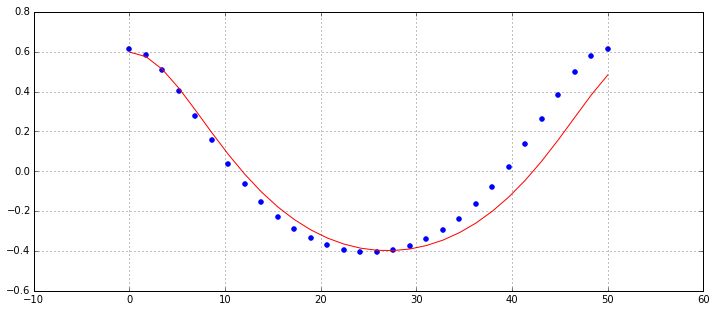

In [42]:
def widgetplot(ind):
    fig1 = plt.figure(figsize=(12,5))
    plt.plot(data_t, getRV(chain[int(ind),:]), color="r");
    plt.scatter(data_t, data_rv, color="b");
    plt.grid()

w = interactive(widgetplot, ind=(0,N_steps-1))
display(w)